In [1]:
import numpy as np
import seaborn as sns
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib
scatter_clr = "slateblue"
line_clr = "orangered"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
params = {'legend.fontsize': 'small',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'large',
         'axes.grid': False,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'xtick.bottom': True,
         'ytick.left': True,}
matplotlib.rcParams.update(params)

# Generate sampling data

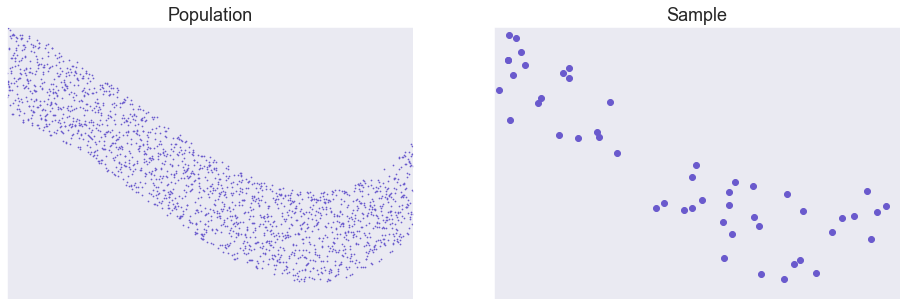

In [3]:
# Let's start with producing a set of 1000 data points that follows the equation:
# Y = 0.75*X^3 - 2.15*X^2 - X + 0.5
X = np.linspace(0, 10, 2000)
np.random.seed(50)
error = np.random.uniform(-20, 20, 2000)
Y = 0.25*(X**3) - 2.5*(X**2) - 5*X + 150 + error

sns.set_style("darkgrid")

fig, axs = plt.subplots(1,2, figsize=(16, 5))
axs[0].scatter(X, Y, s = 0.5, color = scatter_clr)
axs[0].set_title('Population', fontsize = 18)

np.random.seed(50)
sample_idx = np.random.choice(2000, 50)
sample_idx.sort()
X_sample = X[sample_idx]
Y_sample = Y[sample_idx]

sns.set_style("darkgrid")
axs[1].scatter(X_sample, Y_sample, color = scatter_clr)
axs[1].set_title('Sample', fontsize = 18)

for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, 10])
    ax.set_ylim([50, 170])
plt.show()

# Generate prediction models. 

Here, we use scikit-learn PolynomialFeatures to speed up discussion, but interested readers who want to implement this from scratch can read up on the docs.

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def poly_coeff(X_, Y_, degree):
    poly = PolynomialFeatures(degree = degree, interaction_only=False).fit(X_.reshape(-1, 1), Y_)
    poly_features = poly.fit_transform(X_.reshape(-1, 1))
    reg = LinearRegression(fit_intercept = True)
    reg.fit(poly_features, Y_)
    return reg.coef_, reg.intercept_ 

def poly_predict(X_, coef, intercept = 0):
    Y_ = np.zeros((X_.shape))
    for i, a_i in enumerate(coef):
        Y_ += np.power(X_, i) * a_i
    return Y_ + intercept

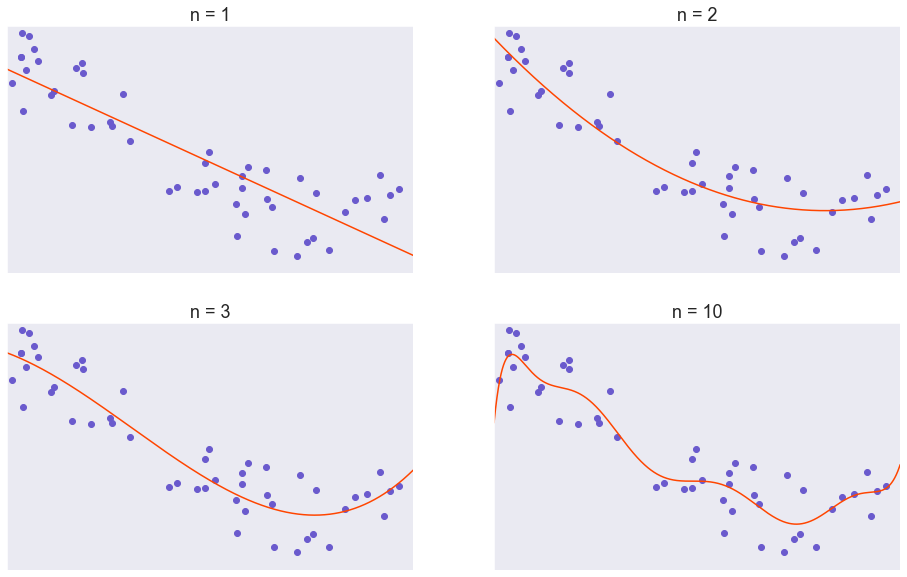

In [5]:
fig, axs = plt.subplots(2,2, figsize=(16, 10))
axs = axs.flatten()
for (i, n) in enumerate([1, 2, 3, 10]):
    # First power polynomial i.e. linear regression model
    coef, intercept = poly_coeff(X_sample, Y_sample, n)
    Y_pred = poly_predict(np.linspace(-1, 11, 2000), coef, intercept)
    
    axs[i].scatter(X_sample, Y_sample, color = scatter_clr)
    axs[i].plot(np.linspace(-1, 11, 2000), Y_pred, color = line_clr)
    axs[i].set_title(f"n = {n}", fontsize = 18)
    
for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, 10])
    ax.set_ylim([50, 170])

plt.show()

# Bias and variance explained

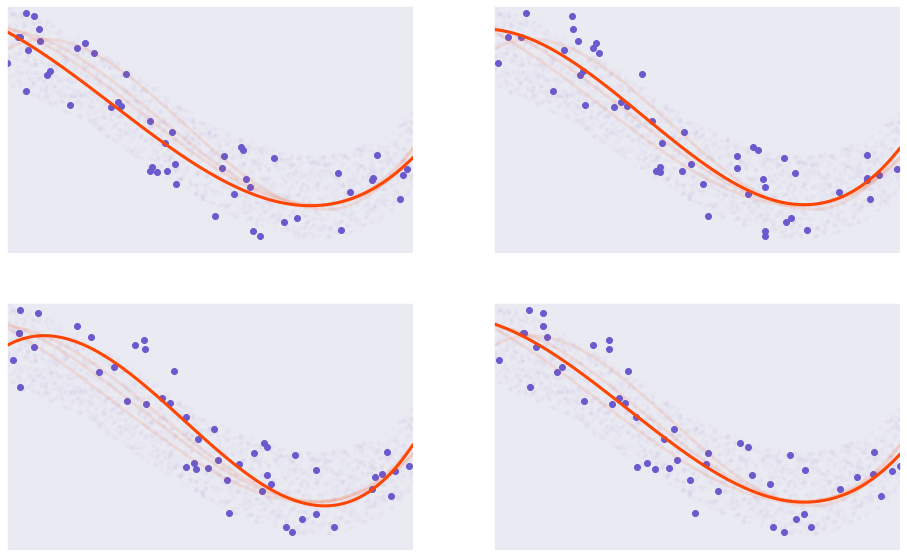

In [6]:
# Different training samples produces models with different parameters
fig, axs = plt.subplots(2,2, figsize=(16, 10))
axs = axs.flatten()
Y_preds = np.zeros((Y.shape[0], 4))
for i in range(4):
    sample_idx = np.random.choice(2000, 50)
    sample_idx.sort()
    X_sample = X[sample_idx]
    coef, intercept = poly_coeff(X_sample, Y_sample, 3)
    Y_pred = poly_predict(X, coef, intercept)
    Y_preds[:,i] = Y_pred
    
    axs[i].scatter(X, Y, alpha = 0.02, s = 10, color = scatter_clr)
    axs[i].scatter(X_sample, Y_sample,  color = scatter_clr)
    axs[i].plot(X, Y_pred, color = line_clr, linewidth = 3)
    
for ax in axs:
    for i in range(4):
        ax.plot(X, Y_preds[:,i], color = line_clr, alpha = 0.1, linewidth = 3)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, 10])
    ax.set_ylim([50, 170])

plt.show()

In [7]:
# Produce models using repeated sampling of the population.

max_n = 10
coefs = np.zeros((100, max_n), dtype=object)
intercepts = np.zeros((100, max_n))

for i in range(100):
    sample_idx = np.random.choice(2000, 50)
    sample_idx.sort()
    X_sample = X[sample_idx]
    Y_sample = Y[sample_idx]
    for n in range(max_n):
        coefs_in, intercept_in = poly_coeff(X_sample, Y_sample, n)
        coefs[i, n] = coefs_in
        intercepts[i, n] = intercept_in

Find the variance of the prediction data

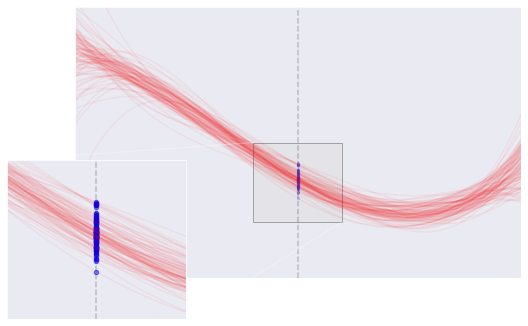

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

X_new = np.array([5.0])

np.random.seed(50)
Y_new = 0.25*(X_new**3) - 2.5*(X_new**2) - 5*X_new + 150 + np.random.uniform(-10, 10)

sns.set_style("darkgrid")
sns.color_palette("deep")
ax = plt.subplot(111)
ax.axvline(x=5.0, color = 'black', linestyle = '--', alpha = 0.2)

axins = zoomed_inset_axes(ax,2,loc= 'lower left', bbox_to_anchor=(0.5, 0.5))
axins.axvline(x=5.0, color = 'black', linestyle = '--', alpha = 0.2)

n = 4
for i in range(100):
    coefs_in = coefs[i,n]
    intercept_in = intercepts[i, n] 
    
    Y_pred = poly_predict(X, coefs_in, intercept_in)
    ax.plot(X, Y_pred, color = "red", alpha = 0.05)
    Y_new_pred = poly_predict(X_new, coefs_in, intercept_in)
    ax.scatter(X_new, Y_new_pred, s = 5.0, marker='o', alpha = 0.20, color = 'blue')
    
    axins.plot(np.linspace(0, 10, 2000), Y_pred, color = "red", alpha = 0.05)
    axins.scatter(X_new, Y_new_pred, s = 20.0, marker='o', alpha = 0.50, color = 'blue')
    
ax.set_xlim([0, 10])
ax.set_ylim([50, 170])

axins.set_xlim(4,6)
axins.set_ylim(75,110)

ax.grid(False)
axins.grid(False)
ax.set_xticks([])
ax.set_yticks([])
axins.set_xticks([])
axins.set_yticks([])
    
pp,p1,p2 = mark_inset(ax,axins, loc1=2, loc2=4, alpha = 0.3)
pp.set_fill(True)
pp.set_facecolor("lightgray")
pp.set_edgecolor("k")
plt.show()


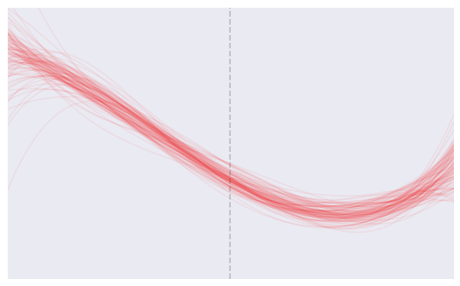

In [12]:
X_new = np.array([5.0])

sns.set_style("darkgrid")
sns.color_palette("deep")
ax = plt.subplot(111)
ax.axvline(x=5.0, color = 'black', linestyle = '--', alpha = 0.2)

n = 4
for i in range(100):
    coefs_in = coefs[i,n]
    intercept_in = intercepts[i, n] 
    
    Y_pred = poly_predict(X, coefs_in, intercept_in)
    ax.plot(X, Y_pred, color = "red", alpha = 0.05)
    
ax.set_xlim([0, 10])
ax.set_ylim([50, 170])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Convert the graphs to bias - variance graph

In [14]:
Y_preds = np.zeros((max_n, 100, 2000))
Y_new_preds = np.zeros((max_n, 100))
for n in range(max_n):
    for i in range(100):
        coefs_in = coefs[i,n]
        intercept_in = intercepts[i, n] 
        Y_preds[n, i, :] = poly_predict(X, coefs_in, intercept_in)
        Y_new_preds[n, i] = poly_predict(X_new, coefs_in, intercept_in)

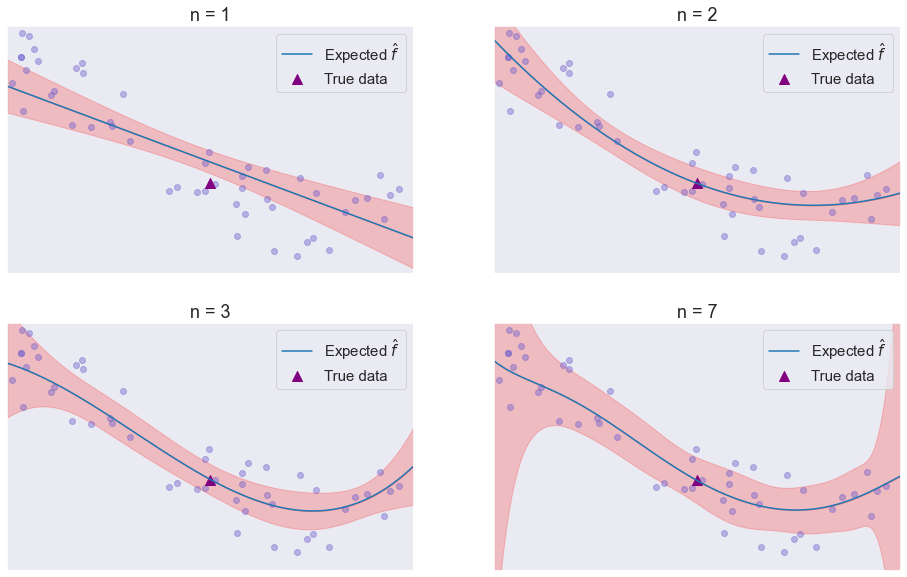

In [19]:
sns.set_style("darkgrid")
sns.color_palette("deep")

mean_Y_preds = np.mean(Y_preds, axis = 1)
var_Y_preds = np.var(Y_preds, axis = 1)

np.random.seed(50)
sample_idx = np.random.choice(2000, 50)
sample_idx.sort()
X_sample = X[sample_idx]
Y_sample = Y[sample_idx]

fig, axs = plt.subplots(2,2, figsize=(16, 10))
axs = axs.flatten()
for (i, n) in enumerate([1, 2, 3, 7]):
    
    mean_Y = mean_Y_preds[n, :]
    var_Y = var_Y_preds[n, :]
        
    axs[i].fill_between(X, mean_Y, mean_Y+np.sqrt(var_Y)*3, color = "red", alpha = 0.2)
    axs[i].fill_between(X, mean_Y, mean_Y-np.sqrt(var_Y)*3, color = "red", alpha = 0.2)
    axs[i].plot(X, mean_Y, label=r'Expected $\hat{f}$')
    
    axs[i].scatter(X_sample, Y_sample, color = scatter_clr, alpha = 0.4)
    axs[i].scatter(X_new, Y_new, s = 100, marker = '^', color = 'purple', label='True data')
    
    axs[i].legend(fontsize = 15)
    axs[i].set_title(f"n = {n}", fontsize = 18)
for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, 10])
    ax.set_ylim([50, 170])
    
plt.show()

Calculate the bias, variance, and MSE

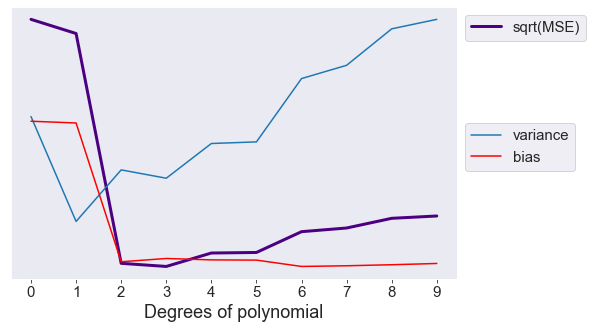

In [183]:
var_Y_new = np.var(Y_new_preds, axis = 1)
mean_Y_new = np.mean(Y_new_preds, axis = 1)
bias_Y_new = mean_Y_new - Y_new

fig, ax1 = plt.subplots()
ax1.grid(False)
MSE = np.mean((Y_new_preds - Y_new)**2, axis = 1)
plt.plot(range(max_n), np.sqrt(MSE), label='sqrt(MSE)', color = 'indigo', linewidth = 3)
plt.legend(loc = 2, bbox_to_anchor=(1, 1), prop={'size': 15})
ax1.set_xticks(range(max_n))
ax1.set_xticklabels(range(max_n), fontsize=15) 
ax1.tick_params(axis="x", bottom=True, labelbottom=True)
ax1.set_yticks([])
ax1.set_xlabel("Degrees of polynomial", fontsize = 18)

ax2 = ax1.twinx()
ax2.grid(False)
plt.plot(range(max_n), var_Y_new, label='variance')
plt.plot(range(max_n), bias_Y_new, label='bias', color = "red")
plt.legend(loc = 2, bbox_to_anchor=(1, 0.6), prop={'size': 15})
ax2.set_yticks([])

plt.show()

# Cross Validation

In [187]:
np.random.seed(20)
sample_idx = np.random.choice(2000, 50)
sample_idx.sort()
X_sample = X[sample_idx]
Y_sample = Y[sample_idx]

In [154]:
# LOOCV
LOOCV_MSE = np.zeros((10,))
for n in range(max_n):
    MSE = 0
    for i in range(50):
        X_train = np.delete(X_sample, i)
        Y_train = np.delete(Y_sample, i)
        X_test = X_sample[i]
        Y_test = Y_sample[i]

        coef, intercept = poly_coeff(X_train, Y_train, n)
        Y_pred = poly_predict(X_test, coef, intercept)
        MSE += (Y_pred - Y_test)**2
    LOOCV_MSE[n] = MSE / 50


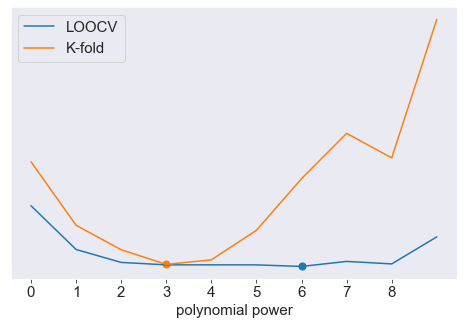

In [186]:
# K-fold
K_MSE = np.zeros((10,))
index = np.random.permutation(50)
for n in range(max_n):
    MSE = 0
    for i in range(10):
        X_train = np.delete(X_sample, range(i*5,(i+1)*5))
        Y_train = np.delete(Y_sample, range(i*5,(i+1)*5))
        X_test = X_sample[i*5:(i+1)*5]
        Y_test = Y_sample[i*5:(i+1)*5]
        
        coef, intercept = poly_coeff(X_train, Y_train, n)
        Y_pred = poly_predict(X_test, coef, intercept)
        MSE += np.sum((Y_pred - Y_test)**2)
    K_MSE[n] = MSE / 50

plt.plot(range(max_n), np.log(LOOCV_MSE), label='LOOCV')
plt.plot(range(max_n), np.log(K_MSE), label='K-fold')
plt.legend(prop={'size': 15})

min_LOOCV = np.argmin(LOOCV_MSE)
min_K = np.argmin(K_MSE)

plt.scatter(min_LOOCV, np.log(LOOCV_MSE[min_LOOCV]), s = 50.0)
plt.scatter(min_K, np.log(K_MSE[min_K]), s = 50.0)
plt.xlabel("polynomial power", fontsize = 15)
#plt.ylabel("MSE")
plt.xticks(range(9), fontsize = 15)
plt.yticks([])
plt.grid(False)